# Examples of structural change in the Abel-Hayashi "Q" investment model

This notebook illustrates the dynamic behavior of capital and its marginal
value in the Abel-Hayashi model of investment when structural changes happen.

I simulate the changes discussed in Prof. Christopher D. Carroll's graduate
Macroeconomics [lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Investment/qModel/):
productivity, corporate tax rate, and investment tax credit changes.

For each change I display the behavior of the model in two different
contexts:
* The change takes place at $t=0$ without notice.
* The change is announced at $t=0$ but takes place at $t=5$.

In [1]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

from Q_investment import Qmod

I first define functions to compute and present optimal dynamics in face of
structural changes.

In [2]:
# Function definitions

def pathValue(invest,mod1,mod2,k0,t):
    '''
    Computes the value of taking investment decisions [i(0),i(1),...,i(t-1)]
    starting at capital k0 and knowing that the prevailing model will switch
    from mod1 to mod2 at time t.
    
    Parameters:
        - invest: vector/list with investment values for periods 0 to t-1
        - mod1  : Qmod object representing the parameter values prevailing from
                  time 0 to t-1.
        - mod2  : Qmod object representing the parameter values prevailing from
                  time t onwards.
        - k0    : capital at time 0.
        - t     : time of the structural change.
    '''
    
    # Initialize capital and value (utility)
    k = np.zeros(t+1)
    k[0] = k0
    value = 0
    
    # Compute capital and utility flows until time t-1
    for i in range(t):
        flow = mod1.flow(k[i],invest[i])
        value += flow*mod1.beta**i
        k[i+1] = k[i]*(1-mod1.delta) + invest[i]
    
    # From time t onwards, model 2 prevails and its value function can be used.
    value += (mod1.beta**t)*mod2.value_func(k[t])
    
    return(value)
            
def structural_change(mod1,mod2,k0,t_change,T_sim,npoints = 300):
    """
    Computes (optimal) capital and lambda dynamics in face of a structural
    change in the Q investment model.
    
    Parameters:
        - mod1    : Qmod object representing the parameter values prevailing
                    from time 0 to t_change-1.
        - mod2    : Qmod object representing the parameter values prevailing
                    from time t_change onwards.
        - k0      : initial value for capital.
        - t_change: time period at which the structural change takes place. It
                    is assumed that the change is announced at period 0.
        - T_sim   : final time period of the simulation.
        - npoints : number of points in the capital grid to be used for phase
                    diagram plots.
    """
    
    # If the change is announced with anticipation, the optimal path of
    # investment from 0 to t_change-1 is computed, as it does not correspond to
    # the usual policy rule.
    if t_change > 0:
        fobj = lambda x: -1*pathValue(x,mod1,mod2,k0,t_change)
        inv = optimize.minimize(fobj,x0 = np.ones(t)*mod1.kss*mod2.delta,
                                options = {'disp': True}).x
    
    # Find paths of capital and lambda
    k = np.zeros(T_sim)
    lam = np.zeros(T_sim)
    k[0] = k0 
    for i in range(0,T_sim-1):
    
        if i < t_change:
            # Before the change, investment follows the optimal
            # path computed above.
            k[i+1] = k[i]*(1-mod1.delta) + inv[i]
            lam[i] = mod1.findLambda(k[i],k[i+1])
        else:
            # After the change, investment follows the post-change policy rule.
            k[i+1] = mod2.k1Func(k[i])
            lam[i] = mod2.findLambda(k[i],k[i+1])
    
    lam[T_sim-1] = mod2.findLambda(k[T_sim-1],mod2.k1Func(k[T_sim-1]))
    
    # Create a figure with phase diagrams and dynamics.
    plt.figure()
    
    # Plot k,lambda path.
    plt.plot(k,lam,'.k')
    plt.plot(k[t_change],lam[t_change],'.r',label = 'Change takes effect')
    
    # Plot the loci of the pre and post-change models.
    k_range = np.linspace(0.1*min(mod1.kss,mod2.kss),2*max(mod1.kss,mod2.kss),
                          npoints)
    mods = [mod1,mod2]
    colors = ['r','b']
    labels = ['Pre-change','Post-change']
    for i in range(2):

        # Plot k0 locus
        plt.plot(k_range,mods[i].P*np.ones(npoints),
                 linestyle = '--', color = colors[i],label = labels[i])
        # Plot lambda0 locus
        plt.plot(k_range,[mods[i].lambda0locus(x) for x in k_range],
                 linestyle = '--', color = colors[i])
        # Plot steady state
        plt.plot(mods[i].kss,mods[i].P,marker = '*', color = colors[i])
    
    plt.title('Phase diagrams and model dynamics')
    plt.xlabel('K')
    plt.ylabel('Lambda')
    plt.legend()
    
    return((k,lam))

## Examples:

## 1. An unanticipated increase in productivity

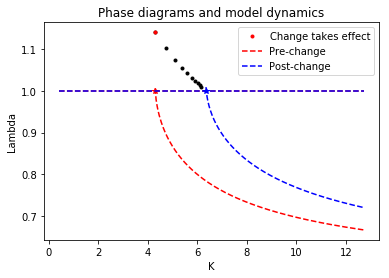

In [3]:
# Create and solve the pre and post-change models.
Q1 = Qmod(psi = 1)
Q1.solve()
Q2 = Qmod(psi = 1.3)
Q2.solve()

# Change happens at t=0.
t = 0
# Simulate for 10 periods.
T = 10
# Start from the steady state of the first model.
k0 = Q1.kss

sol = structural_change(mod1 = Q1, mod2 = Q2, k0 = k0, t_change = t,T_sim=T)

## 2. An increase in productivity announced at t=0 but taking effect at t=5

Optimization terminated successfully.
         Current function value: -78.057692
         Iterations: 11
         Function evaluations: 84
         Gradient evaluations: 12


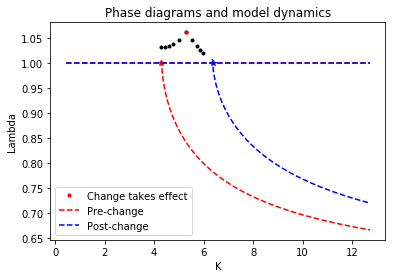

In [4]:
# Repeat the calculation now assuming the change happens at t=5
t = 5

sol = structural_change(mod1 = Q1, mod2 = Q2, k0 = k0, t_change = t,T_sim=T)

## 3. An unanticipated corporate tax-cut

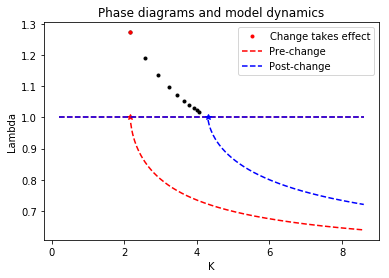

In [5]:
Q1 = Qmod(tau = 0.4)
Q1.solve()
Q2 = Qmod(tau = 0.05)
Q2.solve()

t = 0
T = 10
k0 = Q1.kss

sol = structural_change(mod1 = Q1, mod2 = Q2, k0 = k0, t_change = t,T_sim=T)

## 4. A corporate tax cut announced at t=0 but taking effect at t=5

Optimization terminated successfully.
         Current function value: -51.110475
         Iterations: 9
         Function evaluations: 70
         Gradient evaluations: 10


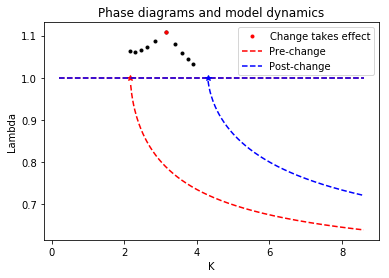

In [6]:
t = 5
sol = structural_change(mod1 = Q1, mod2 = Q2, k0 = k0, t_change = t,T_sim=T)

## 5. An unanticipated ITC increase

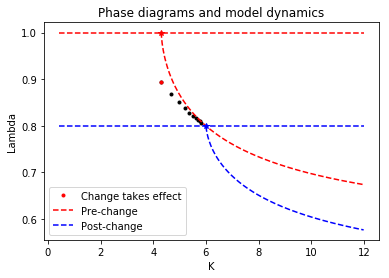

In [7]:
Q1 = Qmod(zeta = 0)
Q1.solve()
Q2 = Qmod(zeta = 0.2)
Q2.solve()

t = 0
T = 10
k0 = Q1.kss

sol = structural_change(mod1 = Q1, mod2 = Q2, k0 = k0, t_change = t,T_sim=T)

## 6. An ITC increase announced at t=0 but taking effect at t=5

Optimization terminated successfully.
         Current function value: -60.398780
         Iterations: 10
         Function evaluations: 77
         Gradient evaluations: 11


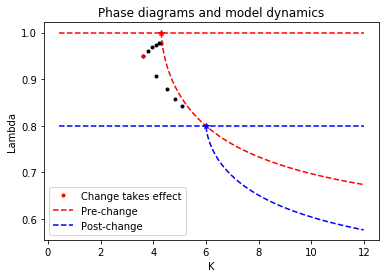

In [8]:
t = 5
sol = structural_change(mod1 = Q1, mod2 = Q2, k0 = k0, t_change = t,T_sim=T)